In [116]:
import os
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform

In [2]:
device = torch.device('cuda:0')

In [132]:
class PingPongDataset(Dataset):
    """Ping pong dataset."""

    def __init__(self, ball_pos, root_dir, img_shape, transform=None):
        """
        Args:
            ball_pos (string): Path to the json file with position annotations.
            root_dir (string): Directory with all the images.
            img_shape (tuple): height and width of image.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.ball_pos = pd.read_json(ball_pos)
        self.root_dir = root_dir
        self.transform = transform
        self.h, self.w = img_shape
        x = np.linspace(0, self.w, self.w)
        y = np.linspace(0, self.h, self.h)
        self.x, self.y = np.meshgrid(x, y)

    def __len__(self):
        return len(self.ball_pos.columns)
    
    def gaussian_2d(self,x=0, y=0, mx=0, my=0, sx=1, sy=1):
        return 1 / (2*math.pi*sx*sy) * \
          np.exp(-((x - mx)**2 / (2*sx**2) + (y - my)**2 / (2*sy**2)))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, f'{self.ball_pos.columns[idx]}.jpg')
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        pos = tuple(self.ball_pos[self.ball_pos.columns[idx]]) # (x,y) coordinates
        z = np.zeros((self.h, self.w))
        z += self.gaussian_2d(self.x, self.y, mx=pos[0], my=pos[1], sx=30, sy=30)
        sample = {'image': image, 'label': z}

        return sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


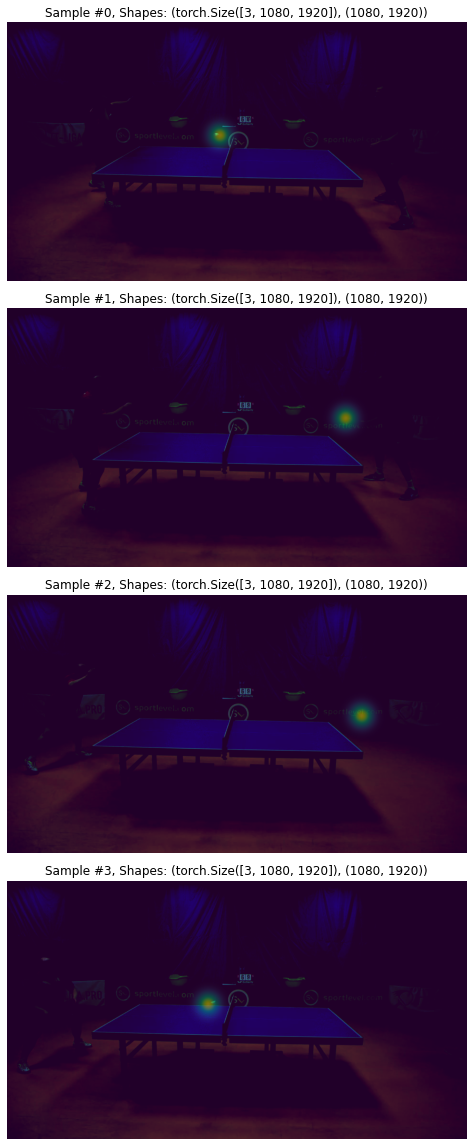

In [133]:
trainset = PingPongDataset(ball_pos='test_3/ball_markup.json',
                                    root_dir='test_3/frames',
                                    img_shape=(1080, 1920),
                                    transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)) ])
                         )

fig = plt.figure(figsize=(10,20))

for i, ind in enumerate(np.random.randint(0,len(trainset)-1, 4)):
    sample = trainset[ind]
    ax = plt.subplot(5, 1, i + 1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}, Shapes: {sample['image'].shape, sample['label'].shape}")
    ax.axis('off')
    # Reorder axis of images for plt.imshow
    plt.imshow(np.transpose(sample['image'], [1,2,0])) 
    plt.imshow(np.transpose(sample['label'], [0,1]), alpha=0.5) 

    if i == 4:
        plt.show()
        break

In [134]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True)
#testloader = torch.utils.data.DataLoader(testset, batch_size=2, shuffle=False)

In [135]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        # Convolution 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5,stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        # Convolution 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5,stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        # Convolution 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x, verbose=False):
        x = F.relu(self.bn1(self.conv1(x)))
        shape1 = x.size()
        x, indices1 = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        shape2 = x.size()
        x, indices2 = self.maxpool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        return [x, indices1, indices2, shape1, shape2]
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # Deconvolution 1
        self.deconv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        # Deconvolution 2
        self.deconv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        # Deconvolution 3
        self.deconv3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x , verbose=False):
        x, indices1, indices2, shape1, shape2 = x
        x = F.relu(self.bn1(self.deconv1(x)))
        x = self.max_unpool(x, indices2, shape2)
        x = F.relu(self.bn2(self.deconv2(x)))
        x = self.max_unpool(x, indices1, shape1)
        x = F.relu((self.deconv3(x)))
        shape = x.shape
        x = softmax(x.view(2, -1)).view(x.shape)
        return x

In [136]:
class TrackNet(nn.Module):
    def __init__(self):
        super(TrackNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x, verbose=False):
        return self.decoder(self.encoder(x))

In [140]:
def test_shapes():
    net = TrackNet()
    net.to(device)

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        x = iter(trainloader).next() # BatchSize, Channels, Width, Height
        images = x['image'].float()
        labels = x['label'].float()
        images = images.to(device)
        print('Shape of the input tensor:', images.shape)
        y = net(images)
        print('Shape of the output tensor:', y.shape)
        print('Sum of the output tensor along axis 1:', y[1,0,:,:].sum())

test_shapes()

Shape of the input tensor: torch.Size([2, 3, 1080, 1920])
Shape of the output tensor: torch.Size([2, 1, 1080, 1920])
Sum of the output tensor along axis 1: tensor(1.0000, device='cuda:0')


#### Training Loop

In [141]:
net = TrackNet()
net.to(device)
epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.BCELoss(reduction='sum')

for epoch in range(epochs):
    loop = tqdm(trainloader)
    train_loss = []
    print(f"Epoch {epoch+1} of {epochs}")
    net.train()
    for idx, batch in enumerate(loop):
        x = batch['image'].float().to(device)
        y = batch['label'].float().to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = loss_fn(y_pred.squeeze(), y.squeeze())
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss=loss.item())
    print(f"Train Loss: {sum(train_loss)/len(train_loss):.4f}")

net.eval()

  0%|                                                                                          | 0/403 [00:00<?, ?it/s]

Epoch 1 of 10


  0%|                                                                                          | 0/403 [00:00<?, ?it/s]

Train Loss: 28.0285
Epoch 2 of 10


Epoch [2/10]:   1%|▋                                                        | 5/403 [00:05<07:35,  1.15s/it, loss=30.4]


KeyboardInterrupt: 

In [142]:
net.eval()
with torch.no_grad():
    x = iter(trainloader).next()
    x = batch['image'].float().to(device)
    y = batch['label'].float().to(device)
    y_pred = net(x)
    print(y_pred.squeeze().shape)

torch.Size([2, 1080, 1920])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


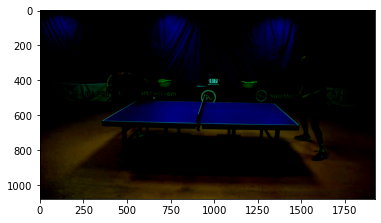

In [143]:
plt.imshow(np.transpose(x[0,:,:].squeeze().cpu(), [1,2,0]))

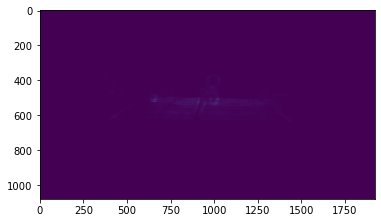

In [144]:
plt.imshow(y_pred[0,:,:].squeeze().cpu())

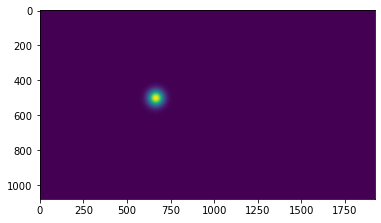

In [145]:
plt.imshow(y[0,:,:].squeeze().cpu())

In [22]:
y_pred.squeeze().sum()

tensor(2073600., device='cuda:0')